In [1]:
import numpy as np

def read_glove2dict(filepath):
    word_embedding_dict = dict()
    with open(filepath, encoding='utf-8') as f:
        for line in f:
            word, *vector = line.split()
            values = np.array(vector, dtype=np.float32)
            word_embedding_dict[word] = values / np.linalg.norm(values)
    return word_embedding_dict

Neat little trick with `word, *vector = line.split()`

In [2]:
word_embedding_dict = read_glove2dict('data/glove.6B.50d.txt')
word_embedding_dict['the'][:5]

array([ 0.08414142,  0.0502594 , -0.08301819,  0.02449763,  0.06950121],
      dtype=float32)

In [3]:
len(word_embedding_dict)

400000

# Find words that are close together in the embedding space
Now find some stuff that is close together:

based on https://stackoverflow.com/a/52364284/1033808

First make a matrix out of the wordembeddings

In [4]:
import pandas as pd

embedding_matrix = np.array(list(word_embedding_dict.values()))
word_indices = pd.Series(list(word_embedding_dict.keys()))

In [5]:
embedding_matrix.shape

(400000, 50)

In [6]:
embedding_matrix

array([[ 0.08414142,  0.0502594 , -0.08301819, ..., -0.03706047,
        -0.02317714, -0.15817983],
       [ 0.00300166,  0.05288691, -0.03773904, ..., -0.12652704,
         0.00998044,  0.06787176],
       [ 0.03410122,  0.06786287, -0.0376971 , ..., -0.0801752 ,
         0.003691  ,  0.02297402],
       ...,
       [-0.11338589,  0.01300567,  0.24176554, ..., -0.0553914 ,
        -0.2492314 ,  0.35142735],
       [-0.172147  , -0.10756864,  0.10744162, ...,  0.17907843,
        -0.0032017 ,  0.14624943],
       [ 0.02231209, -0.15790865,  0.14527115, ..., -0.0580931 ,
        -0.18134622,  0.17070897]], dtype=float32)

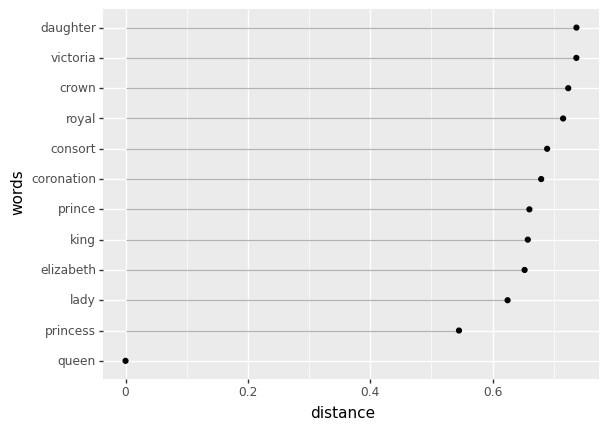

<ggplot: (-9223371912378846397)>

In [7]:
from plotnine import *
from scipy.spatial import cKDTree

# Find words that are close to the target word
target_word = 'queen'
target_embedding_vector = embedding_matrix[int(np.where(word_indices == target_word)[0]),:]
search_result = cKDTree(embedding_matrix).query(target_embedding_vector, k=12)

# Visualise the results
search_plot_data = pd.DataFrame({'words' : word_indices[search_result[1]], 'distance': search_result[0]})
search_plot_data['words'] = pd.Categorical(search_plot_data['words'], categories=search_plot_data['words'])
(
    ggplot(search_plot_data) + 
      geom_point(aes(x='distance', y='words')) + 
      geom_segment(aes(x=0, xend='distance', y='words', yend='words'), alpha=0.3)
)

# Relations and reasoning
Interesting other blogpost: https://blog.acolyer.org/2016/04/21/the-amazing-power-of-word-vectors/

- Calculate PCA of the word embedding matrix and use the first two PC's to plot the concepts
- Vectors between concepts represent relations
- Relations between similar concepts should show similar vectors

# Just separate concepts
Note that we calculate the PCA here locally on just the words we want to plot. Taking all the data, calculating the PCA and then plotting the results does not work. 

In [30]:
from sklearn.decomposition import PCA

words = ['horse', 'cow', 'monkey', 'cat', 'apple', 'banana', 'pear', 'mango',
         'car', 'bus', 'truck', 'bike', 'computer', 'calculator', 'keyboard', 'mouse']

plot_word = pd.DataFrame(PCA(n_components=2).fit_transform([word_embedding_dict[w] for w in words]), 
                         columns=['PC1', 'PC2'])

# plot_word = pd.DataFrame([get_pca(w) for w in words], columns=['PC1', 'PC2'])
plot_word['word'] = words
plot_word['type'] = list(pd.Series(['animal', 'fruit', 'transport', 'PC stuff']).repeat(4))
plot_word

,PC1,PC2,word,type
0,-0.201838,-0.169569,horse,animal
1,0.122286,-0.198355,cow,animal
2,0.313476,0.149713,monkey,animal
3,0.091604,0.104023,cat,animal
4,0.270187,0.100138,apple,fruit
5,0.480357,-0.437391,banana,fruit
6,0.765313,-0.206318,pear,fruit
7,0.662952,-0.320319,mango,fruit
8,-0.613593,-0.253936,car,transport
9,-0.632833,-0.326243,bus,transport


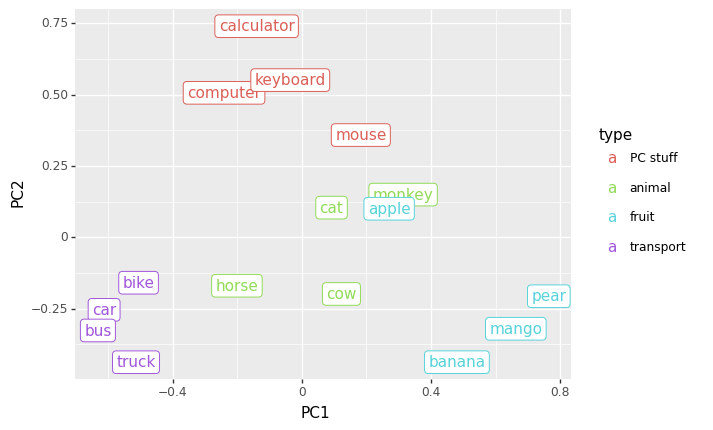

<ggplot: (-9223371912377338592)>

In [36]:
(
    ggplot(plot_word, aes(x='PC1', y='PC2')) + 
      geom_point(aes(color='type')) + 
      geom_label(aes(label='word', color='type'))
)

Nice:
- Mouse inbetween computer stuff and animals
- Horse is closer to the transportation stuff
- Apple is a bit weird

# Relations, e.g. capital of

In [11]:
country_capitals = ['china', 'bejing', 'russia', 'moscow', 'japan', 'tokyo', 
                    'turkey', 'ankara', 'spain', 'madrid', 'france', 'paris',
                    'portugal', 'lisbon', 'greece', 'athens', 'italy', 'rome',
                    'netherlands', 'amsterdam', 'germany', 'berlin']
plot_word = pd.DataFrame(PCA(n_components=2).fit_transform([word_embedding_dict[w] for w in country_capitals]), 
                         columns=['PC1', 'PC2'])
plot_word['word'] = country_capitals
plot_word

,PC1,PC2,word
0,0.428981,-0.302689,china
1,0.663960,0.355083,bejing
2,0.240704,-0.301003,russia
3,0.166692,0.215064,moscow
4,0.500534,-0.238014,japan
5,0.421453,0.268060,tokyo
6,0.350270,-0.323594,turkey
7,0.430213,0.098751,ankara
8,-0.379599,-0.373908,spain
9,-0.417567,0.163554,madrid


In [12]:
plot_word['concept'] = pd.Series(['country', 'capital'] * int(len(plot_word) / 2))
plot_word['country'] = list(pd.Series(['china', 'russia', 'japan', 'turkey', 'spain', 'france', 'portugal', 'greece', 'italy', 'netherlands', 'germany']).repeat(2))
plot_word

,PC1,PC2,word,concept,country
0,0.428981,-0.302689,china,country,china
1,0.663960,0.355083,bejing,capital,china
2,0.240704,-0.301003,russia,country,russia
3,0.166692,0.215064,moscow,capital,russia
4,0.500534,-0.238014,japan,country,japan
5,0.421453,0.268060,tokyo,capital,japan
6,0.350270,-0.323594,turkey,country,turkey
7,0.430213,0.098751,ankara,capital,turkey
8,-0.379599,-0.373908,spain,country,spain
9,-0.417567,0.163554,madrid,capital,spain


In [13]:
res = plot_word.pivot(index='country', columns='concept')
res.columns = ['_'.join(col).strip() for col in res.columns.values]
res

,PC1_capital,PC1_country,PC2_capital,PC2_country,word_capital,word_country
country,,,,,,
china,0.663960,0.428981,0.355083,-0.302689,bejing,china
france,-0.397866,-0.376525,0.304989,-0.221539,paris,france
germany,-0.047582,-0.030706,0.364831,-0.140581,berlin,germany
greece,0.186102,0.158921,0.281075,-0.227008,athens,greece
italy,-0.329937,-0.297380,0.179326,-0.286189,rome,italy
japan,0.421453,0.500534,0.268060,-0.238014,tokyo,japan
netherlands,-0.320347,-0.294713,0.484289,-0.125157,amsterdam,netherlands
portugal,-0.320521,-0.335087,0.162822,-0.338161,lisbon,portugal
russia,0.166692,0.240704,0.215064,-0.301003,moscow,russia


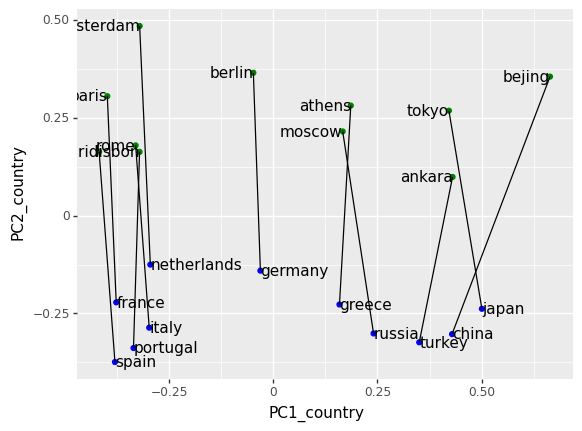

<ggplot: (124476215560)>

In [14]:
(
    ggplot(res) + 
      geom_point(aes(x='PC1_country', y='PC2_country'), color='blue') + 
      geom_text(aes(x='PC1_country', y='PC2_country', label='word_country'), ha='left') + 
      geom_point(aes(x='PC1_capital', y='PC2_capital'), color='green') + 
      geom_text(aes(x='PC1_capital', y='PC2_capital', label='word_capital'), ha='right') +
      geom_segment(aes(x = 'PC1_country', xend='PC1_capital', y='PC2_country', yend='PC2_capital'))
)

# Reasoning
Doe nog iets met 

Then we can just solve for x = Paris - France + Poland.

Sure enough, the most similar vector is x ≈ Warsaw!

In [17]:
search_vector = word_embedding_dict['paris'] - word_embedding_dict['france'] + word_embedding_dict['poland']
search_result = cKDTree(embedding_matrix).query(search_vector, k=1)
word_indices[search_result[1]]

'warsaw'